In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import shap
shap.initjs()

c:\Users\Violet\Documents\GitHub\PerovskiteML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import custom scripts
from scripts import *

Data utils loaded


In [3]:
# Threshold (%) of data for a feature to be included
THRESHOLD = 0.75
# Depth Threshold (%) of data included from layer data.
# --- picks the maximum depth that includes the threshold % of devices
DEPTH_THRESHOLD = 0.75

TARGET_COL = "JV_default_PCE"

In [4]:
data, selector = preprocess_data(
    THRESHOLD,
    DEPTH_THRESHOLD,
    exclude_sections=[
      "Reference information",
      "Cell definition",
      "Outdoor testing",
    #   "Additional layers",
      "JV data"
      ],
    exclude_cols=[
      "Outdoor_time_start",
      "Outdoor_time_end"
      ],
    verbose=False
)

# Process target data
mask = DATASET.data[TARGET_COL].notna()
X = data[mask]
y = DATASET.data[mask][TARGET_COL]

print(X.shape)
print(y.shape)

c:\Users\Violet\Documents\GitHub\PerovskiteML\src\notebooks
Loading Perovskite Data...
../../data/Perovskite_database_content_all_data_040524.csv
Loading Reference Data...
../../data/pdp_units_data.xlsx
Data Initialized.
Preprocessing Data...
Threshold: 0.75, Depth: 0.75
Data Preprocessed.
(42258, 61)
(42258,)


In [5]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

preprocessor = ColumnTransformer([
    ('numerical', 'passthrough', selector['numerical']),
    ('categorical', encoder, [*selector['categorical'], *selector['patterned']]),
])

# # scaler = StandardScaler().set_output(transform="pandas")
# # preprocessor = make_pipeline(column_preprocessor, scaler)

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbregressor', xgb_model)
])
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['Module_number_of_cells_in_module',
                                                   'Perovskite_deposition_number_of_deposition_steps',
                                                   'Stability_average_over_n_number_of_cells',
                                                   'Stability_flexible_cell_number_of_bending_cycles']),
                                                 ('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_val...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.2f}, RMSE: {mse**0.5:.2f}")

MSE: 11.40, RMSE: 3.38


In [7]:
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
display_scores(-scores)

Scores: [3.96583407 3.99635668 3.85592578 4.07438684 4.34179904]
Mean: 4.047
Std: 0.163


In [8]:
all_columns = [*selector['numerical'], *selector['categorical'], *selector['patterned']]
X_transformed = pd.DataFrame(model.named_steps['preprocessor'].transform(X))
X_transformed.columns = all_columns

X_display = X[all_columns]

explainer = shap.TreeExplainer(model.named_steps['xgbregressor'])
shap_values = explainer.shap_values(X_transformed)

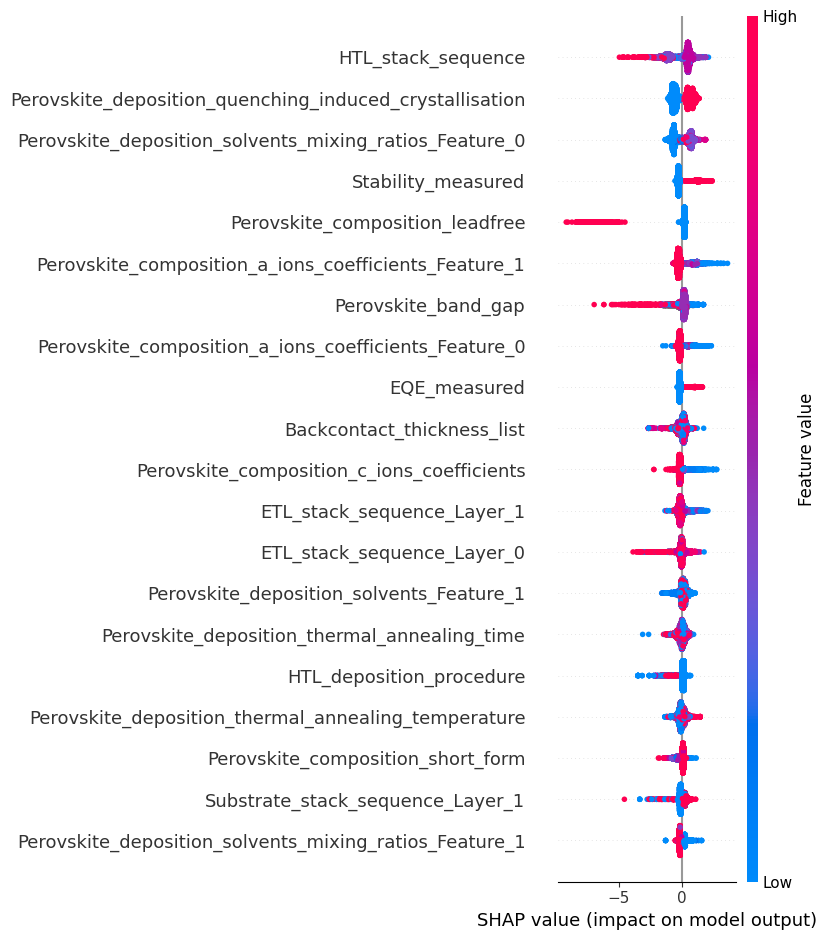

In [9]:
shap.summary_plot(shap_values[:10000, :], X_transformed.iloc[:10000, :])

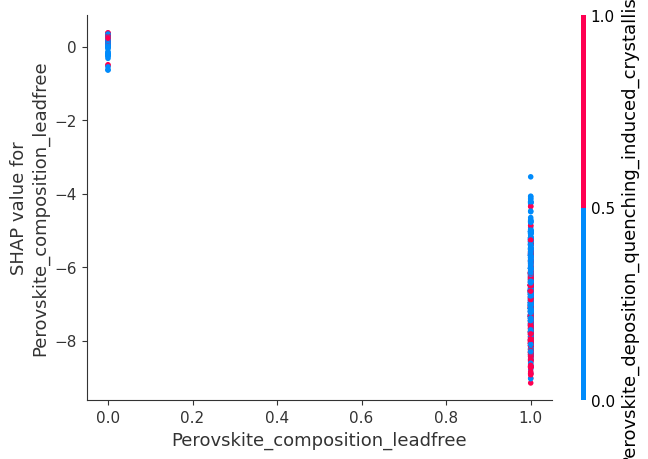

In [10]:
shap.dependence_plot('Perovskite_composition_leadfree', shap_values, X_transformed, display_features=X_display)

In [12]:
shap.force_plot(explainer.expected_value, shap_values[40000, :], X_display.iloc[40000, :])